In [125]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [126]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse
import cv2

import theano
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
from sklearn import datasets

print 'Keras ', keras.__version__
print 'Theano', theano.__version__
print 'OpenCV', cv2.__version__
print 'Numpy ', np.__version__

Keras  1.2.1
Theano 0.8.2
OpenCV 2.4.10
Numpy  1.10.4


In [127]:
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Carregando nosso modelo pre-treinado

In [128]:
print("[INFO] loading model...")
model_name = './keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)
print 'Layers:'
for i, layer in enumerate(model.layers):
    print '  {:2d}: {:15s} {}'.format(i, layer.__class__.__name__, layer.name)
print
model_A.summary()

[INFO] loading model...
[INFO] evaluating...
 9984/10000 [============================>.] - ETA: 0s[INFO] accuracy: 99.34%
Layers:
   0: Convolution2D   convolution2d_1
   1: Activation      activation_1
   2: MaxPooling2D    maxpooling2d_1
   3: Convolution2D   convolution2d_2
   4: Activation      activation_2
   5: MaxPooling2D    maxpooling2d_2
   6: Dropout         dropout_1
   7: Flatten         flatten_1
   8: Dense           dense_1
   9: Activation      activation_3
  10: Dense           dense_2
  11: Activation      activation_4

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 20, 28, 28)    520         convolution2d_input_18[0][0]     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 20, 28, 28

## Avaliando a performance

In [ ]:
print("[INFO] evaluating...")
loss, accuracy = model_A.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

In [129]:
W_all_A = model_A.get_weights()
print [W.shape for W in W_all_A]

[(20, 1, 5, 5), (20,), (50, 20, 5, 5), (50,), (2450, 500), (500,), (500, 10), (10,)]


In [130]:
from keras.models import Model
out_6 = Model(input=model_A.input, output=model_A.get_layer('dropout_1').output).predict(X_test[:1])[0]

out_7 = Model(input=model_A.input, output=model_A.get_layer('flatten_1').output).predict(X_test[:1])[0]

out_8 = Model(input=model_A.input, output=model_A.get_layer('dense_1').output).predict(X_test[:1])[0]

In [131]:
np.set_printoptions(precision=3)
print out_6.shape, out_7.shape, out_8.shape
print out_6[0]
print


(50, 7, 7) (2450,) (500,)
[[ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.434  0.314  0.     2.128  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.641  0.     0.     0.   ]
 [ 0.     0.     0.827  1.798  0.     0.     0.   ]
 [ 0.     0.     1.524  0.     0.     0.     0.   ]]



## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

In [132]:
model_name = './keras_lenet_fullconv'

class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, 5, 5, border_mode="same", 
                                input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Convolution2D(500, 7, 7, border_mode="valid"))        
        model.add(Activation("relu"))

        model.add(Convolution2D(10, 1, 1, border_mode="valid"))        
        model.add(Flatten())
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

model_B = LeNet.build(width=28, height=28, depth=1, classes=10)
model_B.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_37 (Convolution2D) (None, 20, 28, 28)    520         convolution2d_input_19[0][0]     
____________________________________________________________________________________________________
activation_35 (Activation)       (None, 20, 28, 28)    0           convolution2d_37[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 20, 14, 14)    0           activation_35[0][0]              
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 50, 14, 14)    25050       maxpooling2d_19[0][0]            
___________________________________________________________________________________________

## Ajustando os pesos do modelo todo convolucional

In [143]:
W_all_B = model_B.get_weights()
print [W.shape for W in W_all_B]

W_all_B = [
    W_all_A[0],
    W_all_A[1],
    W_all_A[2],
    W_all_A[3],
    W_all_A[4].T.reshape(500, 50, 7, 7)[:, :, ::-1, ::-1],
    W_all_A[5],
    W_all_A[6].T.reshape(10, 500, 1, 1)[:, :, ::-1, ::-1],
    W_all_A[7],
]
model_B.set_weights(W_all_B)


## Verificando a performance

In [144]:
model_B.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

print("[INFO] evaluating...")
loss, accuracy = model_B.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] evaluating...
10000/10000 [==============================] - 7s     
[INFO] accuracy: 99.34%


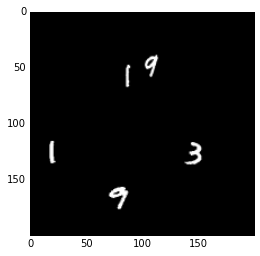

In [136]:
N = 5
char_index = np.random.choice(X_test.shape[0], N, replace=False)
char_img = [img.reshape(28,28) for img in (255*X_test).astype(np.uint8)[char_index]]

image = np.zeros((200, 200), np.uint8)
for k, (i, j) in enumerate(np.random.choice(200-28, (N, 2), replace=False)):
    image[i:i+28, j:j+28] = np.maximum(image[i:i+28, j:j+28], char_img[k])
    
plot.imshow(image, cmap=plot.cm.gray)

In [139]:
model_B.internal_input_shapes = None
pp = model_B.predict(np.zeros((1,1,28,28)))
pp.max()

0.12954895